# Run pw. qpAdm Model for all indivdiuals of the early cluster

Goal: Show that this cluster is heterogenous
In other analysis it was already established that there is substantial heterogeneity

In [54]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
os.sys.path.append(path)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Do qpAdm Function Imports and Definitions

In [55]:
from python.run_qpadm import qpAdm_run, get_meta_ind_table, modifiy_iid_files, set_iids_to_label
from python.plot_qpadm import plot_qpadm, load_pvals

### Parameters for qpAdm_run are set there!
a12 = ["Mota", "Ust_Ishim", "Kostenki14", "GoyetQ116-1", "Vestonice16", "MA1",
           "ElMiron", "Villabruna", "EHG", "CHG", "Natufian",
           "Levant_N"] # List of ancient European populations for right populations
distal = ["Anatolia_N", "WHG", "Steppe_EMBA", 
          "Iran_N", "Morocco_EN.SG"]
print(f"# Anc_Euro: {len(a12)} populations")
print(f"# Distal sources:{len(distal)} populations")

# Anc_Euro: 12 populations
# Distal sources:5 populations


# 1) Modify .ind File

### 1a) Prepare Early Punic Individuals
Load data table with individual assignments - and produce modified .ind file for use in qpadm

In [56]:
### Populations to overwrite. Typically because they have the ".SG" label
vrs = "49.2"
ind_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"          # What .ind to load
ind_modified = f"./eigenstrat/anc_only.v{vrs}.punic_early_ind.ind"    # Where to save the modified version to

df_ind = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

df_lbs = pd.read_csv("./data/cluster_assignments_punic.v49.2.tsv", sep="\t")  ### Load external Label file (Google docs)

### Reset Clusters
for _, row in df_lbs.iterrows():
    iid = row['iid']
    
    idx = df_ind["iid"] == iid
    if np.sum(idx)<1:
        print(f"Warning, {iid} not found in original .ind file.")
    
    df_ind.loc[idx, "clst"] = row["clst_qpadm"]
    ### Reset All the Individuals in the Target Ind
    #df_ind = set_iids_to_clst(df_ind, iids=iids, clst=g, savepath="")

### Overwrite PunicCentralMedEarly
idx = df_ind["clst"]=="PunicCentralMedEarly"
df_p_cm_early = df_ind[idx].copy()
iids = df_p_cm_early["iid"].values
df_ind = set_iids_to_label(df_ind, iids_overwrite=iids)

df_ind.to_csv(ind_modified, header=False, sep=" ", index=False)
print(f"Saved updated {len(df_ind)} IIDs to: {ind_modified}")

Loaded 1142 Individuals
Warning, I26842 not found in original .ind file.
Overwriting 18 Individuals
Saved updated 1142 IIDs to: ./eigenstrat/anc_only.v49.2.punic_early_ind.ind


In [11]:
### Give out the IIDs
iids

array(['I4798', 'I4799', 'I4800', 'I12666', 'I12847', 'I22115', 'I22121',
       'I22122', 'I22117', 'I22118', 'I22232', 'I22096', 'I24678',
       'I24676', 'I24675', 'I24556', 'I22095', 'I18201'], dtype=object)

# 2) Run qpAdm

### Test run for pair of indiviuals

In [12]:
%%time

target = "I4798"  
sources = ["I4799"]  # Morocco_EN.SG, Algeria_IA
rightpops = a12 + ["Morocco_EN.SG", "Iran_N"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early_ind",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 64.207009
CPU times: user 5.68 ms, sys: 7.5 ms, total: 13.2 ms
Wall time: 1min 4s


0

# Run all possible pairs

In [ ]:
for p in it.combinations(iids, r=2):  ### One run was with r=1
    rightpops = a12 + ["Morocco_EN.SG", "Iran_N"]
    leftpops = list(p)
    
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".punic_early_ind",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/early_punic_pairs_ind/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 64.303255
Runtime: 64.388395
Runtime: 64.606390


In [57]:
iids

array(['I4798', 'I4799', 'I4800', 'I12666', 'I12847', 'I22115', 'I22121',
       'I22122', 'I22117', 'I22118', 'I22096', 'I22236', 'I24678',
       'I24676', 'I24675', 'I24556', 'I22095', 'I18201'], dtype=object)

# Manually rerun addtional individuals

In [ ]:
iids_p = ['I24675', 'I12666', 'I24556',
          'I22095', 'I12847', 'I24678', 'I24676', 
          'I4798', 'I4799', 'I4800', 'I22232', "I22115", 'I22121',
          'I22096', 'I22118', 'I22117', 'I22122', 'I18201']

for p in iids_p:  ### One run was with r=1
    rightpops = a12 + ["Morocco_EN.SG", "Iran_N"]
    leftpops = ["I22236", p]
    
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".punic_early_ind",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/early_punic_pairs_ind/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 46.552066
Runtime: 46.648896


# 2) Pick up the p-values

In [7]:
def get_p_mat_ordered(df, pops):
    """Get p Matrix matching
    the list pops"""
    k=len(pops)
    pops=np.array(pops)
    combs = np.array(list(it.product(pops, repeat=2)))
    df_pairs = pd.DataFrame(combs)
    df_pairs.columns = ["ind1", "ind2"]
    
    ### Flip rows of f_st dataframe
    df1 = df.copy()
    df1["ind2"], df1["ind1"] = df["ind1"], df["ind2"]
    df = df.append(df1).sort_index().reset_index(drop=True)
    
    df_merge = pd.merge(df_pairs, df, on=["ind1", "ind2"], how="left")
    p_mat = df_merge["p"].values.reshape((k,k))
    return p_mat

In [12]:
%%time
ps=[]
inds =[]

for pr in it.combinations(iids, r=2): 
    rs=load_pvals(f"./output/qpAdm/v49.2/early_punic_pairs_ind/{pr[0]}.{pr[1]}.log")
    ps.append(rs[0])
    inds.append(rs[1])
inds = np.array(inds)

df = pd.DataFrame({"ind1":inds[:,0], "ind2":inds[:,1], "p":ps})

CPU times: user 74 ms, sys: 52.1 ms, total: 126 ms
Wall time: 4.2 s


### 3b) Load the IIDs + Labels

In [40]:
df_lbs = pd.read_csv("./data/cluster_assignments_punic.v49.2.tsv", sep="\t")  ### Load external Label file (Google docs)
idx = df_lbs["clst_qpadm"]=="PunicCentralMedEarly"


df2 = df_lbs[idx].copy()
df2.index = df2["iid"].values

iids = df2["iid"].values

In [51]:
def plot_p_2d(iids, df, labels=[], figsize=(16,14), title="", vrange=[], 
            fsl=4, fs_t=12, fs=14, mpl=100, rotation=45, alpha=0.9,
            fmt = " %.1f", full=True, show=False, 
            savepath="", cmap = "viridis"):
    """Create 2D colored plot of all combinations of IIds.
    df: Dataframe of pairwise p Values
    iids: Which IIDs to plot
    labels: The axis labels for the axis. (has to match pops in order).
    If none given, plot default
    v_range: What range for the color values. If none, choose automatically
    fsl: Fontsize
    mpl: Multiplicator of f value for better visualition
    full: Whether to show the full Matrix
    show: Whether to plot the picture
    cmap: What colormap to use: viridis, viridis_r"""
        
    if len(vrange)>0:
        vmin, vmax = vrange[0], vrange[1]
    else:
        vmin, vmax = np.min(df["p"]), np.max(df["p"])
    k = len(iids)
    print("Nr. of IIDs to plot: %i" % k)
    plot_mat = get_p_mat_ordered(df, iids)
        
    if full:
        mask = np.diag(np.ones(k))
    
    elif full==False:
        mask = np.logical_not(np.tri(k, k=-1)).T  # Mask out triangular matrix
    
    plot_mat = np.ma.array(plot_mat, mask=mask)   # Mask out the Diagonal
    f = plot_mat.flatten().compressed() # So that list of entries for plotting values
        
    #### plot the figure
    plt.figure(figsize=figsize)
    plt.axis("equal")

    ax=plt.gca()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    c = plt.pcolor(plot_mat, vmin=vmin, vmax=vmax, alpha=alpha, cmap=cmap)  # cmap RdBu
    
    def show_values(pc, fmt=fmt):    # Comment out %.3f \n" + r"$\pm$" + r"%.4f"
        pc.update_scalarmappable()
        #ax = pc.get_axes()
        for p, color, f0 in zip(pc.get_paths(), pc.get_facecolors(), f):  # pc.get_array()
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[1] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)   
            label = f"{(f0 * mpl):.2f}"
            ax.text(x, y, label, ha="center", va="center", color=color, fontsize=fsl)

    show_values(c, fmt = " ")
    
    
    if len(labels)>0:
        plt.xticks(np.arange(k) + 0.5, labels, rotation=rotation, fontsize=fs_t, 
                   ha="right", rotation_mode="anchor") # 'vertical'
        plt.yticks(np.arange(k) + 0.5, labels, rotation=rotation, fontsize=fs_t, 
                   ha="right", rotation_mode="anchor") # 'horizontal'
        
    plt.colorbar()
    plt.title(title, fontsize=fs)
    
    if full: 
        low=0.0    
    else: low=1.0
        
    plt.xlim([low, k])
    plt.ylim([0.0,k])
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Figure saved to {savepath}")
    if show:
        plt.show()

Nr. of IIDs to plot: 18


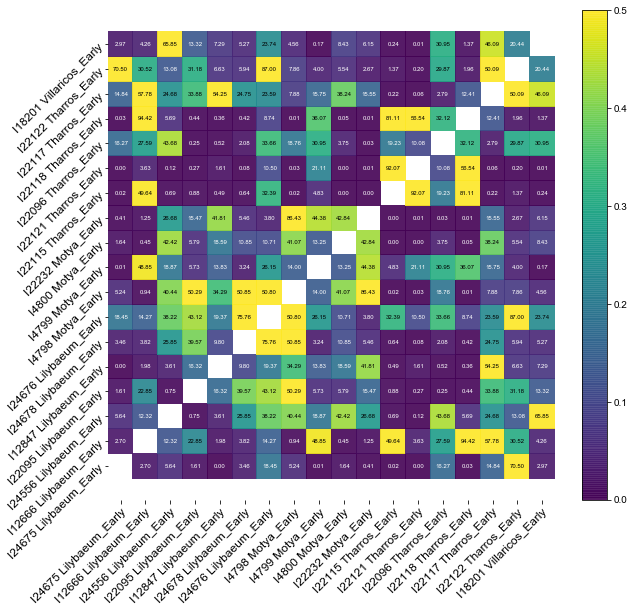

In [53]:
iids_p = ['I24675', 'I12666', 'I24556',
          'I22095', 'I12847', 'I24678', 'I24676', 
          'I4798', 'I4799', 'I4800', 'I22232', "I22115", 'I22121',
          'I22096', 'I22118', 'I22117', 'I22122', 'I18201']
df3 = df2.loc[iids_p].copy()
lbs = df3["iid"] + " " + df3["label_fine"]
lbs = lbs.values

plot_p_2d(iids=iids_p, df=df, figsize=(10,9), labels=lbs, fsl=6, 
          vrange=[0,0.5], savepath="", mpl=100)

# Make a histogram of pairwise p-Values

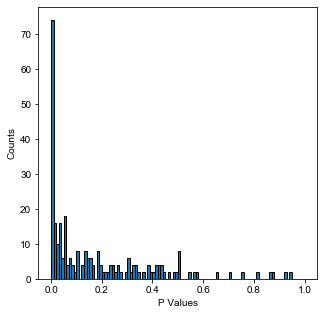

In [18]:
bins = np.linspace(0,1,101)

plt.figure(figsize=(5,5))

ax = plt.gca()
ax.hist(ps.flatten(), ec="k", bins=bins)
ax.set_xlabel("P Values")
ax.set_ylabel("Counts")
plt.show()